# CSCI3330 Tutorial 3: Camera Image Signal Processing (ISP) Pipeline

This tutorial demonstrates a basic Image Signal Processing (ISP) pipeline in digital cameras.

The ISP pipeline is essential for converting raw image data captured by the camera sensor into a visually pleasing image. We use an open-source implementation for efficient ISP operations in Python, the FastOpenISP(https://github.com/QiuJueqin/fast-openISP). The FastOpenISP is an efficient version of OpenISP. The original OpenISP will be more easy-to-read than the FastOpenISP if you are interested in the source code.

### Preration

Mount Google Drive to read the sample RAW file.

In [1]:
###
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'csci3330/tut3'
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/csci3330/tut3


We use the [RawPy](https://github.com/letmaik/rawpy) to read RAW files. The RawPy is a Python wrapper of the C++ library [libraw](https://www.libraw.org/), the most famous open-source RAW image encoder.

In [2]:
%pip install rawpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.0 MB/s eta 0:00:00


# Let's start!

In [7]:
import os
import os.path as op

import numpy as np
import rawpy
from PIL import Image
import matplotlib.pyplot as plt

%pip install pipeline

In [8]:
def visualize_intermediates(intermediates):
  print(f'{len(intermediates)} images are given.')
  assert len(intermediates) < 17, 'Too many intermediates to visualize.'
  plt.figure(figsize=(16, 12))
  idx = 1
  for module_name, result in intermediates.items():
    image = pipeline.get_output(result)
    plt.subplot(4, 4, idx)
    plt.title(module_name)
    if len(image.shape) == 2:
      plt.imshow(image, cmap='gray')
    else:
      plt.imshow(image)
    idx += 1

##[*`raw image processing operations`*](https://)

dpc: dead pixel correction \
blc: black level compensation \
aaf: \
awb: auto white balance \
cnf: reduce chromatic noise (before demosaicing) \
cfa: demosaicing \
ccm: color correction matrix: transfer from device idpd space to eg XYZ space \
gac: gamma correction
csc: color space correction: eg convert color space to sRGB \
nlm: non local mean, bnf: biliniar: denoising \
ceh: contrast enhancing \
eeh: edge enhancing \

in hardware, it is done in costumized dsp, and are accelerated. In python, the similation might be slow


In [10]:
# from pipeline import Pipeline
from utils.yacs import Config

raw_path = 'raw/test-CUHK.ARW'
raw_file = rawpy.imread(raw_path)
bayer = raw_file.raw_image.astype(np.uint16)
print("RAW (Bayer) shape=", bayer.shape)
plt.figure(figsize=(12, 16))
plt.imshow(bayer, cmap='gray')

ModuleNotFoundError: No module named 'utils'

### Execute the Pipeline!

[*`can't flip or crop the image before running. there will be default eg the top left corner is R.`*]()

In [ ]:
cfg = Config('configs/test_conf.yaml')

pipeline = Pipeline(cfg)
_, intermediates = pipeline.execute(bayer, save_intermediates=True)
visualize_intermediates(intermediates)

NameError: name 'Config' is not defined

**Question: Can we flip the image before the pipeline is executed? What should we do to keep the correctness?**


### The result seems bad... Why?

We are using the default parameters in the ISP pipeline!

Please note that each RAW photo need specific parameters in the ISP pipeline. These parameters are usually included in the EXIF header of the RAW file.

The package RawPy will automatically load series of essential parameters from the EXIF header of the RAW file.

For more details of the EXIF headers, please refer to format specification of corresponding RAW file (e.g., Adobe DNG).

parameters are in the raw file

In [ ]:
# These metadata keys are encapsulated by RawPy (actually read by libraw).
# For more EXIF data, you may use other specific packages,
#  or directly read and parse from bytes according to the format specification.
meta_data = {
    'camera_whitebalance': raw_file.camera_whitebalance,
    'color_matrix': raw_file.color_matrix,
    'rgb_xyz_matrix': raw_file.rgb_xyz_matrix,
    'black_level_per_channel': raw_file.black_level_per_channel,
    'raw_pattern': raw_file.raw_pattern,
    'tone_curve': raw_file.tone_curve
}

for k, v in meta_data.items():
  print(f'{k}:\n{v}\n')

camera_whitebalance:
[2620.0, 1024.0, 1952.0, 1024.0]

color_matrix:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

rgb_xyz_matrix:
[[ 0.7657 -0.2847 -0.0607]
 [-0.4083  1.1966  0.2389]
 [-0.0684  0.1418  0.5844]
 [ 0.      0.      0.    ]]

black_level_per_channel:
[512, 512, 512, 512]

raw_pattern:
[[0 1]
 [3 2]]

tone_curve:
[    0     1     2 ... 65533 65534 65535]



Executing dpc... bayer.shape= (4024, 6048)
Done. Elapsed 4.200s
Executing blc... Done. Elapsed 0.254s
Executing aaf... Done. Elapsed 0.650s
Executing awb... Done. Elapsed 0.188s
Executing cnf... Done. Elapsed 2.038s
Executing cfa... Done. Elapsed 2.118s
Executing ccm... Done. Elapsed 1.413s
Executing gac... Done. Elapsed 0.639s
Executing csc... Done. Elapsed 0.961s
Executing eeh... Done. Elapsed 2.706s
Executing fcs... Done. Elapsed 1.164s
Pipeline elapsed 18.364s
11 images are given.


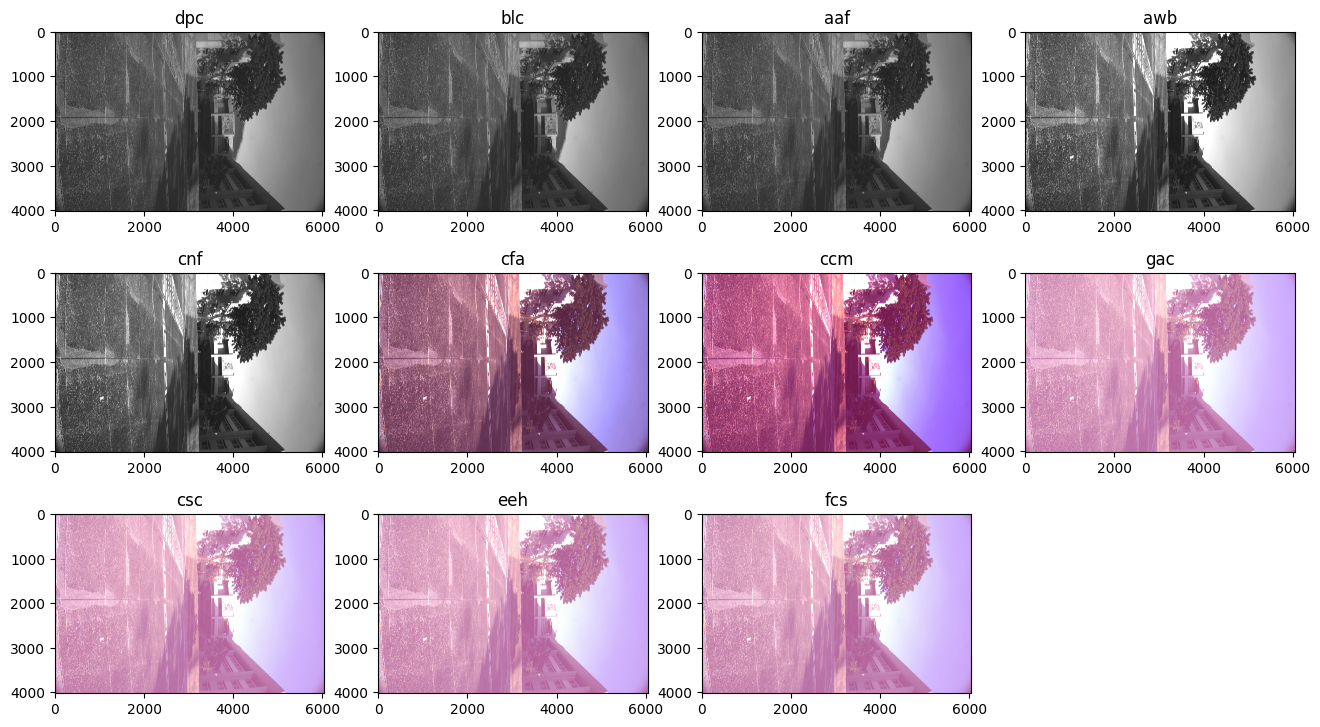

In [ ]:
cfg = Config('configs/test_conf.yaml')

# Fix the white balance parameter from the EXIF metadata
with cfg.unfreeze():
  cfg.awb.r_gain = meta_data['camera_whitebalance'][0]
  cfg.awb.gr_gain = meta_data['camera_whitebalance'][1]
  cfg.awb.gb_gain = meta_data['camera_whitebalance'][3]
  cfg.awb.b_gain = meta_data['camera_whitebalance'][2]

pipeline = Pipeline(cfg)
_, intermediates_fix_wb = pipeline.execute(bayer, save_intermediates=True)
visualize_intermediates(intermediates_fix_wb)

### Wait... The color seems better, but why it looks faded?

We forgot to substract the black level, which means the original black color in our rendered photo will look gray!



Executing dpc... bayer.shape= (4024, 6048)
Done. Elapsed 3.095s
Executing blc... Done. Elapsed 0.201s
Executing aaf... Done. Elapsed 0.616s
Executing awb... Done. Elapsed 0.181s
Executing cnf... Done. Elapsed 1.992s
Executing cfa... Done. Elapsed 1.817s
Executing ccm... Done. Elapsed 1.300s
Executing gac... Done. Elapsed 0.853s
Executing csc... Done. Elapsed 1.399s
Executing eeh... Done. Elapsed 2.969s
Executing fcs... Done. Elapsed 0.810s
Pipeline elapsed 16.668s
11 images are given.


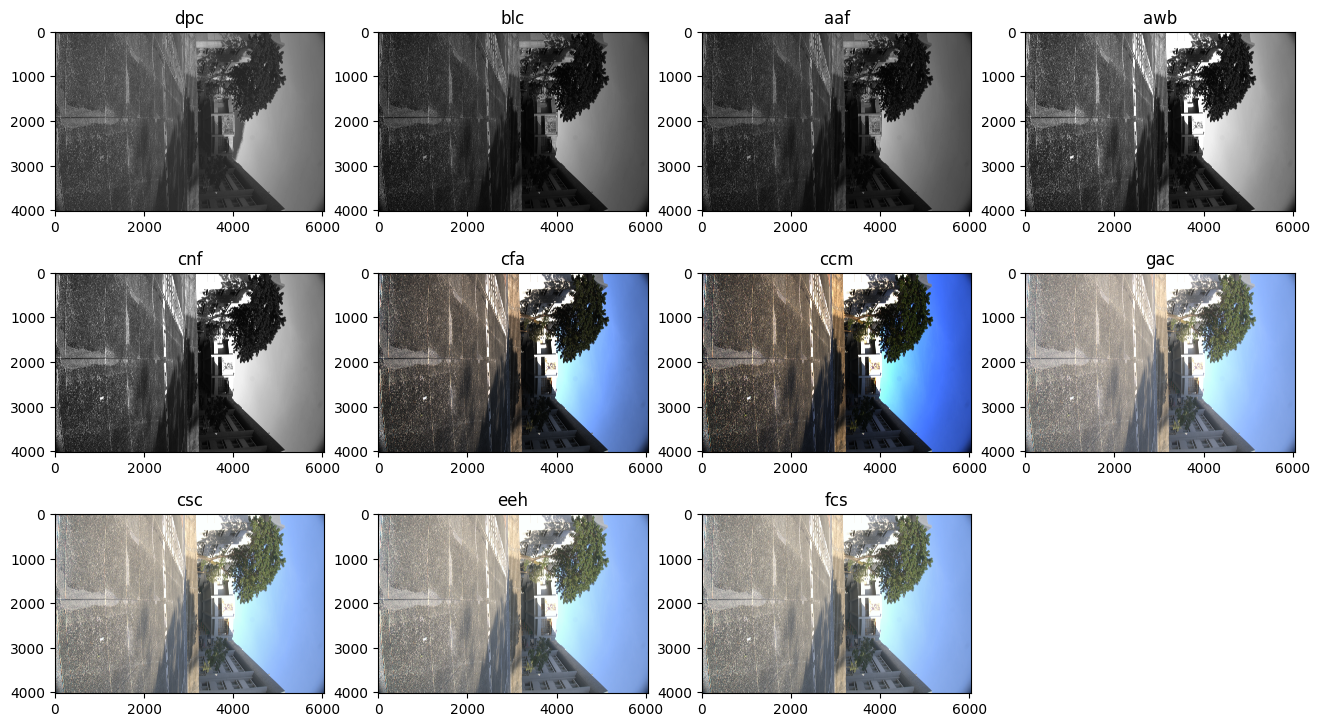

In [ ]:
cfg = Config('configs/test_conf.yaml')

# Fix the white balance parameter from the EXIF metadata
with cfg.unfreeze():
  # Insert black level parameters from metadata
  cfg.blc.bl_r = meta_data['black_level_per_channel'][0]
  cfg.blc.bl_gr = meta_data['black_level_per_channel'][1]
  cfg.blc.bl_gb = meta_data['black_level_per_channel'][2]
  cfg.blc.bl_b = meta_data['black_level_per_channel'][3]

  # Insert WB parameters from metadata
  cfg.awb.r_gain = meta_data['camera_whitebalance'][0]
  cfg.awb.gr_gain = meta_data['camera_whitebalance'][1]
  cfg.awb.gb_gain = meta_data['camera_whitebalance'][3]
  cfg.awb.b_gain = meta_data['camera_whitebalance'][2]

pipeline = Pipeline(cfg)
_, intermediates_fix_wb_blc = pipeline.execute(bayer, save_intermediates=True)
visualize_intermediates(intermediates_fix_wb_blc)

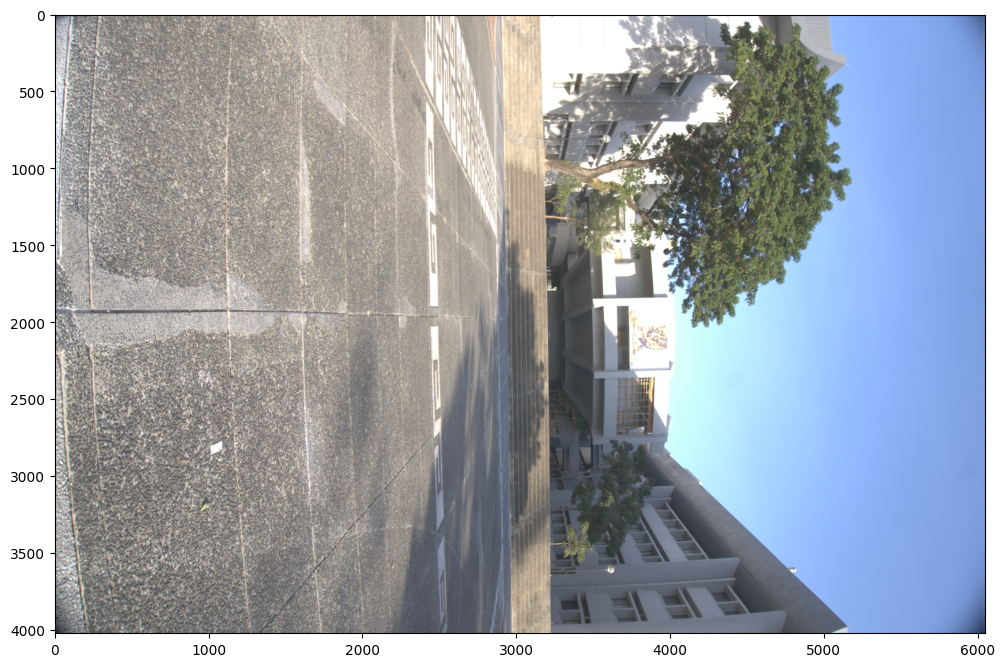

In [ ]:
plt.figure(figsize=(12, 16))
plt.imshow(intermediates_fix_wb_blc['fcs']['rgb_image'])

### Now it's better. But we still forgot something.

**Please note the the CCM is device-dependent (model-dependent)!**

Some devices also provide a tone curve in the metadata.


Text(0.5, 1.0, 'Original Tone Curve (0-4096)')

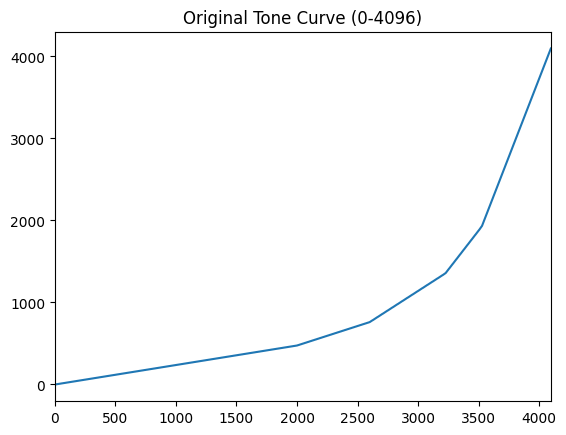

In [ ]:
max_possible_value = 2 ** 12  # 12-bit
tone_curve_x = np.linspace(0, max_possible_value, max_possible_value)
tone_curve_y = meta_data['tone_curve'][0: max_possible_value]
tone_curve_y = tone_curve_y / np.max(tone_curve_y)
tone_curve_y *= 4096
tone_curve_y = tone_curve_y.astype(np.int32)
plt.figure()
plt.plot(tone_curve_x, tone_curve_y)
plt.xlim(0, max_possible_value)
plt.title('Original Tone Curve (0-4096)')

Executing dpc... bayer.shape= (4024, 6048)
Done. Elapsed 3.151s
Executing blc... Done. Elapsed 0.191s
Executing aaf... Done. Elapsed 0.617s
Executing awb... Done. Elapsed 0.176s
Executing cnf... Done. Elapsed 2.154s
Executing cfa... Done. Elapsed 1.867s
Executing ccm... Done. Elapsed 1.447s
Executing gac... Done. Elapsed 1.383s
Executing csc... Done. Elapsed 1.367s
Executing eeh... Done. Elapsed 2.870s
Executing fcs... Done. Elapsed 0.792s
Pipeline elapsed 17.361s
11 images are given.


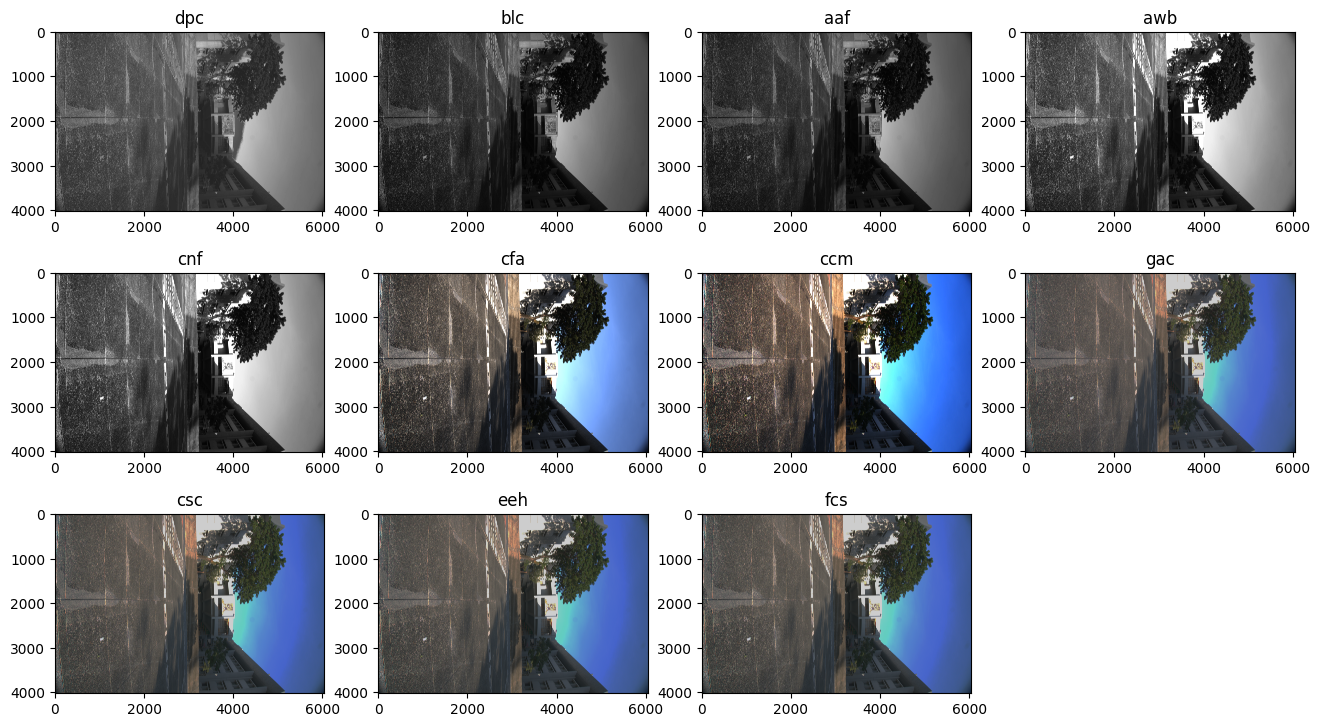

In [ ]:
cfg = Config('configs/test_conf.yaml')

with cfg.unfreeze():
    # Insert black level parameters from metadata
    cfg.blc.bl_r = meta_data['black_level_per_channel'][0]
    cfg.blc.bl_gr = meta_data['black_level_per_channel'][1]
    cfg.blc.bl_gb = meta_data['black_level_per_channel'][2]
    cfg.blc.bl_b = meta_data['black_level_per_channel'][3]

    # Insert WB parameters from metadata
    cfg.awb.r_gain = meta_data['camera_whitebalance'][0]
    cfg.awb.gr_gain = meta_data['camera_whitebalance'][1]
    cfg.awb.gb_gain = meta_data['camera_whitebalance'][3]
    cfg.awb.b_gain = meta_data['camera_whitebalance'][2]

    # Insert the CCM of Sony A6400.
    # Note to fit the acceptable shape of the CCM API.
    cfg.ccm.ccm = np.array([
          [2.05, -0.96, -0.09, 0],
          [-0.19, 1.57, -0.38, 0],
          [0.09, -0.56, 1.47, 0]
    ]) * 1024

    cfg.gac.tone_curve = True
    cfg.tone_curve = tone_curve_y


pipeline = Pipeline(cfg)
final_output_tone_mapped, intermediates_fix_wb_blc_ccm = pipeline.execute(bayer, save_intermediates=True)
visualize_intermediates(intermediates_fix_wb_blc_ccm)

Text(0.5, 1.0, 'Output Image (tone-mapped)')

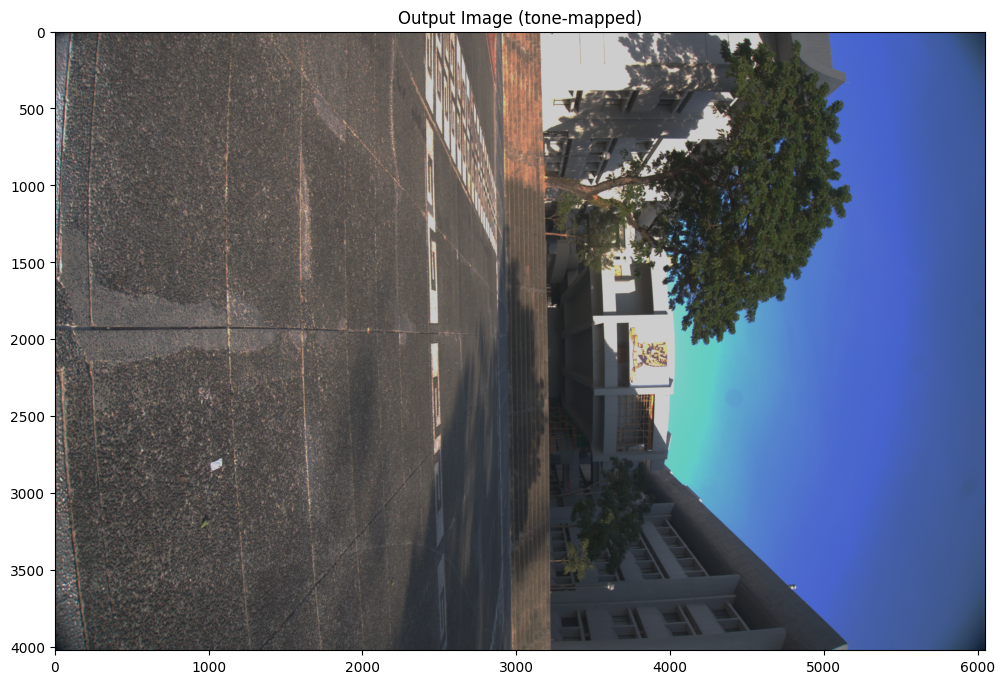

In [ ]:
plt.figure(figsize=(12, 16))
plt.imshow(final_output_tone_mapped['rgb_image'])
plt.title('Output Image (tone-mapped)')

### Still want to improve?

There are a group of people in camera/smartphone companies called camera aesthetic tuning experts (e.g., have you heard of the Leica Look?).
They craft the ISP (both designing algorithms and tuning parameters) to make the output photos of their products look geogerous in most scenes.

What is beauty is quite a subject topic and everyone has a different taste.



# Night Scene

The main difference between the photos taken in daytime and nighttime is the intensity of light. Less light means more noises.

For RAW images taken at night, it is necessary to apply more adavanced denoising method.


RAW (Bayer) shape= (4024, 6048)


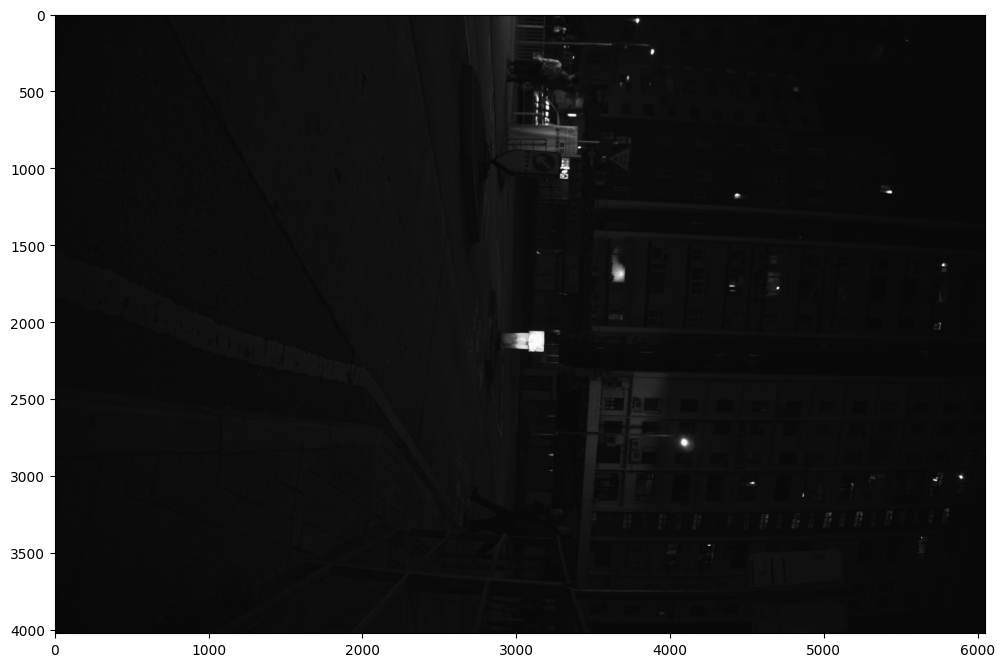

In [ ]:
raw_path = 'raw/test-Night.ARW'
raw_file = rawpy.imread(raw_path)
bayer_night = raw_file.raw_image.astype(np.uint16)
print("RAW (Bayer) shape=", bayer.shape)
plt.figure(figsize=(12, 16))
plt.imshow(bayer_night, cmap='gray')

In [ ]:
cfg = Config('configs/test_conf.yaml')

with cfg.unfreeze():
    # Insert black level parameters from metadata
    cfg.blc.bl_r = meta_data['black_level_per_channel'][0]
    cfg.blc.bl_gr = meta_data['black_level_per_channel'][1]
    cfg.blc.bl_gb = meta_data['black_level_per_channel'][2]
    cfg.blc.bl_b = meta_data['black_level_per_channel'][3]

    # Insert WB parameters from metadata
    cfg.awb.r_gain = meta_data['camera_whitebalance'][0]
    cfg.awb.gr_gain = meta_data['camera_whitebalance'][1]
    cfg.awb.gb_gain = meta_data['camera_whitebalance'][3]
    cfg.awb.b_gain = meta_data['camera_whitebalance'][2]

    # Insert the CCM of Sony A6400.
    # Note to fit the acceptable shape of the CCM API.
    cfg.ccm.ccm = np.array([
          [2.05, -0.96, -0.09, 0],
          [-0.19, 1.57, -0.38, 0],
          [0.09, -0.56, 1.47, 0]
    ]) * 1024

    cfg.gac.tone_curve = True
    cfg.tone_curve = tone_curve_y


pipeline = Pipeline(cfg)
final_output, _ = pipeline.execute(bayer_night, save_intermediates=False)

Text(0.5, 1.0, 'Night Output (without denoising)')

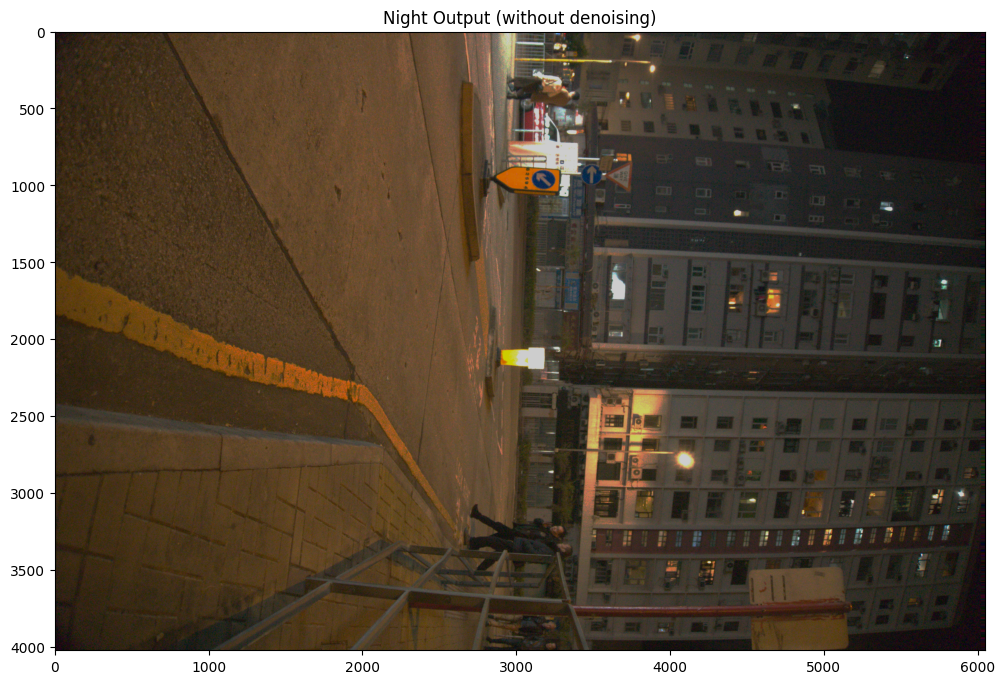

In [ ]:
plt.figure(figsize=(12, 16))
plt.imshow(final_output['rgb_image'])
plt.title('Night Output (without denoising)')

We can add some denoising algorithms (non-local means and bilateral filtering) to reduce the noises.

In [ ]:
cfg = Config('configs/test_conf.yaml')

with cfg.unfreeze():
    # Insert black level parameters from metadata
    cfg.blc.bl_r = meta_data['black_level_per_channel'][0]
    cfg.blc.bl_gr = meta_data['black_level_per_channel'][1]
    cfg.blc.bl_gb = meta_data['black_level_per_channel'][2]
    cfg.blc.bl_b = meta_data['black_level_per_channel'][3]

    # Insert WB parameters from metadata
    cfg.awb.r_gain = meta_data['camera_whitebalance'][0]
    cfg.awb.gr_gain = meta_data['camera_whitebalance'][1]
    cfg.awb.gb_gain = meta_data['camera_whitebalance'][3]
    cfg.awb.b_gain = meta_data['camera_whitebalance'][2]

    # Insert the CCM of Sony A6400.
    # Note to fit the acceptable shape of the CCM API.
    cfg.ccm.ccm = np.array([
          [2.05, -0.96, -0.09, 0],
          [-0.19, 1.57, -0.38, 0],
          [0.09, -0.56, 1.47, 0]
    ]) * 1024

    cfg.gac.tone_curve = True
    cfg.tone_curve = tone_curve_y
    cfg.module_enable_status.nlm = True
    cfg.module_enable_status.bnf = True


pipeline = Pipeline(cfg)
final_output2, _ = pipeline.execute(bayer_night, save_intermediates=False)

Executing dpc... bayer.shape= (4024, 6048)
Done. Elapsed 3.925s
Executing blc... Done. Elapsed 0.253s
Executing aaf... Done. Elapsed 0.685s
Executing awb... Done. Elapsed 0.217s
Executing cnf... Done. Elapsed 2.251s
Executing cfa... Done. Elapsed 2.246s
Executing ccm... Done. Elapsed 1.500s
Executing gac... Done. Elapsed 1.155s
Executing csc... Done. Elapsed 1.156s
Executing nlm... Done. Elapsed 59.172s
Executing bnf... Done. Elapsed 9.373s
Executing eeh... Done. Elapsed 2.723s
Executing fcs... Done. Elapsed 0.799s
Pipeline elapsed 86.861s


Text(0.5, 1.0, 'Night Output (with NLM and BNF)')

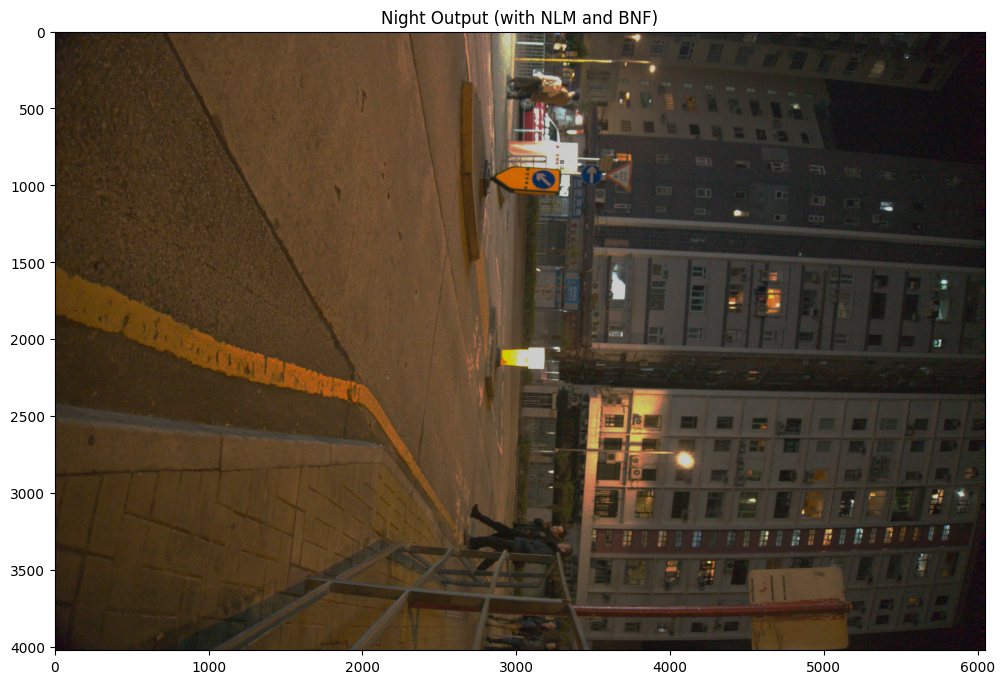

In [ ]:
plt.figure(figsize=(12, 16))
plt.imshow(final_output2['rgb_image'])
plt.title('Night Output (with NLM and BNF)')

Text(0.5, 1.0, 'with NLM and BNF')

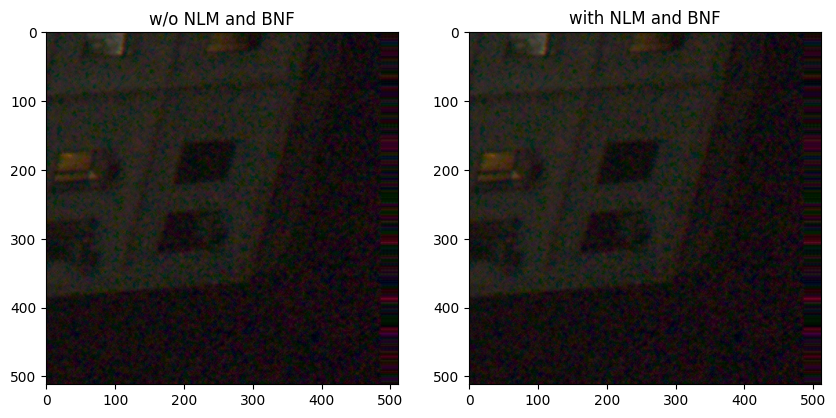

In [ ]:
plt.figure(figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(final_output['rgb_image'][-768:, -256:, :])
plt.title('w/o NLM and BNF')
plt.subplot(1, 2, 2)
plt.imshow(final_output2['rgb_image'][-768:, -256:, :])
plt.title('with NLM and BNF')

# Thank you!

In the next tutorial, we will discuss how to improve the photo quality using HDR algorithms.